**Mount google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
dataset = '/content/drive/My Drive/Mushrooms'

**Prepare Iimage dataset for deep learning models by applying image transformations and loading it into a PyTorch Dataset object.**

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=dataset, transform=transform)


**Installs the PyTorch Lightning library, which provides a high-level interface for PyTorch**

In [5]:
!pip install pytorch_lightning -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
import keras
import torch
from torchvision import models
from torchvision import transforms
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch import nn
import pytorch_lightning as pl
import glob 
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

**Set up a dataset of mushroom images by extracting subdirectories for each mushroom type, counting the number of classes, and getting the file paths for each image in the dataset.**

In [7]:
image_dir = '/content/drive/My Drive/Mushrooms'
g_type_list = [x.split('/')[-1] for x in glob.glob(os.path.join(image_dir, '[A-Z]*'))]
print(g_type_list)
num_classes = len(g_type_list)
train_image_names = glob.glob(os.path.join(image_dir, '*', '*.jpg'))
print("Total number of training images: ", len(train_image_names))

train_image_names = pd.Series(train_image_names)


['Hygrocybe', 'Boletus', 'Amanita', 'Cortinarius', 'Suillus', 'Russula', 'Lactarius', 'Agaricus']
Total number of training images:  6350


**Few random images from each mushroom type in the dataset and display them in a grid using matplotlib.**

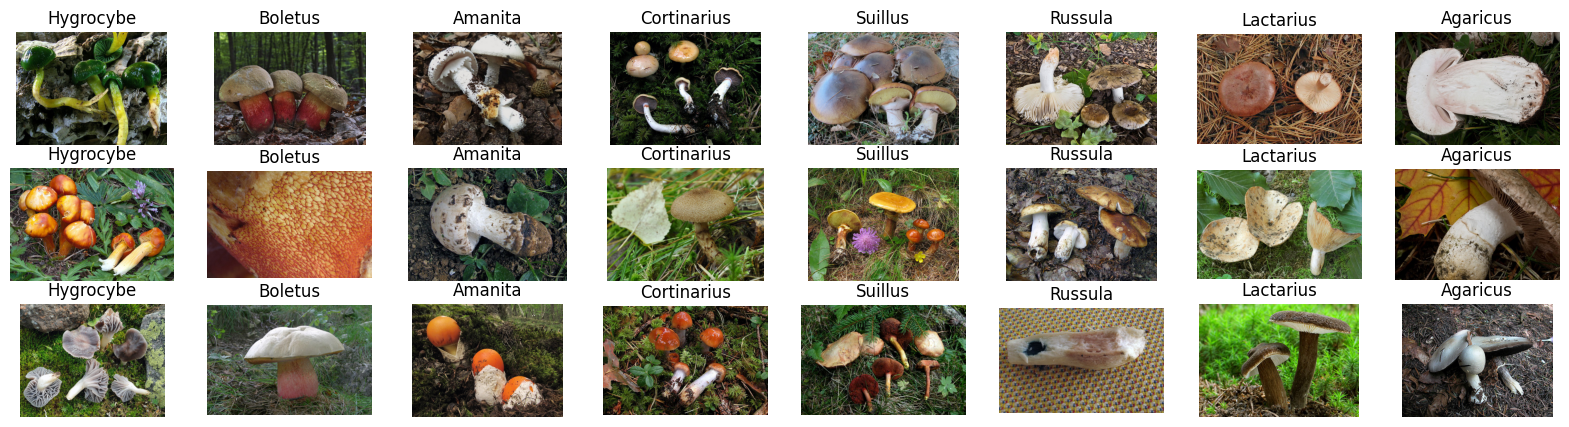

In [8]:
num_per_genus = 3
random_images = []
random_images_labels = []

for g in g_type_list:
    g_img_list = glob.glob(os.path.join(image_dir, g+'/*jpg'))
    num_img = len(g_img_list)
    if num_img > 0:
        rand_img_ind = np.random.choice(np.arange(0, num_img), size=num_per_genus, replace=False)
        random_images += [g_img_list[i] for i in rand_img_ind]
        random_images_labels += [g]*num_per_genus

f, ax = plt.subplots(num_per_genus, num_classes, figsize=(20,5))
for i, sample in enumerate(random_images):
    ax[i%num_per_genus, i//num_per_genus].imshow(plt.imread(sample))
    ax[i%num_per_genus, i//num_per_genus].axis('off')
    ax[i%num_per_genus, i//num_per_genus].set_title(random_images_labels[i])

plt.show() 


**Function that creates a countplot using seaborn to visualize the distribution of mushroom types in a given dataset.**

In [9]:
def plot_distribution(dataset: datasets, dataset_type: str) -> None:
    
    mushroom_names = { 
    0: "Hygrocybe", 
    1: "Boletus", 
    2: "Amanita",
    3: "Cortinarius", 
    4: "Suillus",
    5: "Russula",
    6: "Lactarius",
    7: "Agaricus"
}
    plot_order = ['Hygrocybe', 'Boletus', 'Amanita', 'Cortinarius', 'Suillus', 'Russula', 'Lactarius', 'Agaricus']
    label_list = []
    for i in range(0, len(dataset)):
        label_list.append(mushroom_names[dataset[i][1]])
        
    s = sns.countplot(label_list, order=plot_order)
        
    plt.ylim(0,1700) if dataset_type in ["Actual dataset", "Train dataset"] else plt.ylim(0, 400)
    _ = plt.xticks(s.get_xticks(), rotation=60, ha='right')
    s.set_title(dataset_type)
    
    return s



In [10]:
def plot_distribution(image_dir: str, dataset_type: str) -> None:

    
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    dataset = datasets.ImageFolder(root=image_dir, transform=transform)

    
    data = []
    for i in range(len(dataset)):
        data.append({'path': dataset.imgs[i][0], 'label': dataset.imgs[i][1]})
    df = pd.DataFrame(data)

    # Map label integer to class name string
    class_names = {0: "Hygrocybe", 1: "Boletus", 2: "Amanita", 3: "Cortinarius", 4: "Suillus", 5: "Russula", 6: "Lactarius", 7: "Agaricus"}
    df['class_name'] = df['label'].map(class_names)

    # Plot distribution
    sns.countplot(data=df, x='class_name', order=class_names.values())
    plt.ylim(0,1700) if dataset_type in ["Actual dataset", "Train dataset"] else plt.ylim(0, 400)
    plt.xticks(rotation=60, ha='right')
    plt.title(dataset_type)
    plt.show()


**Visualizes the distribution of mushroom types in the dataset**

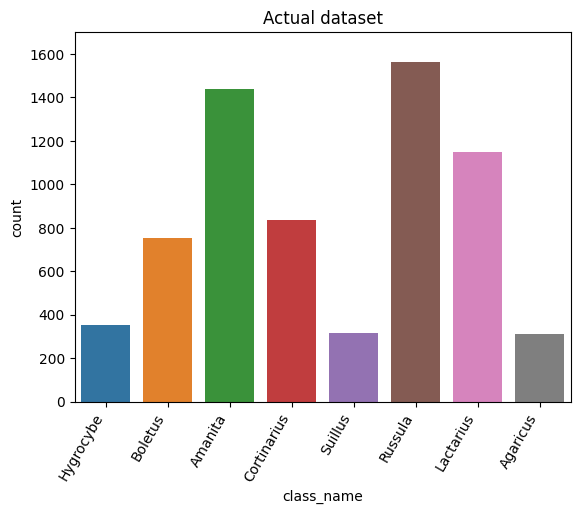

In [11]:
image_dir = '/content/drive/My Drive/Mushrooms'
plot_distribution(image_dir, "Actual dataset")


In [12]:
def autolabel(bar_plot):
    """
    Attach a text label above each bar displaying its height
    """
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

In [13]:
print(len(dataset))

6714


In [14]:
import random
from torch.utils.data import random_split

# assume dataset is a PyTorch dataset object

# set the percentages for train, val, and test sets
train_pct = 0.7
val_pct = 0.2
test_pct = 0.1

# calculate the lengths of each set based on the percentages
num_samples = len(dataset)
train_len = int(train_pct * num_samples)
val_len = int(val_pct * num_samples)
test_len = num_samples - train_len - val_len

# use random_split to split the dataset
train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

In [15]:
print(len(train_set))
print(len(val_set))
print(len(test_set))


4699
1342
673


**Image classification model using PyTorch Lightning**

In [16]:
class ImageClassifier(pl.LightningModule):
    
    def __init__(self, train_set, val_set, test_set, data_dir='/content/drive/My Drive/Mushrooms', 
                 num_classes=8, lr=1e-3):
        
        super().__init__()
        self.save_hyperparameters()
        
        self.backbone = models.resnet50(pretrained=True)
        self.finetune_layer = torch.nn.Linear(self.backbone.fc.out_features, num_classes)
        
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set
        
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        
        
    def setup(self, stage: str = None):
        """
        ImageClassifier accepts training, validation and test sets from outside. These sets 
        are unprocessed images, so following transformations are applied to them: resizing 
        to 255x255 pixels, center cropping to 224x224 pixels and normalization. 
        """
        
        transformations = transforms.Compose([transforms.Resize(255),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                   std=[0.229, 0.224, 0.225])
                                             ])
        self.train_set.dataset.transform = transformations
        self.val_set.dataset.transform = transformations
        self.test_set.dataset.transform = transformations
    
    
    def calculate_loss(self, logits, labels):
        """
        Calculates the cross-entropy loss function
        """
        return nn.CrossEntropyLoss()(logits, labels)


    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=128, num_workers=4, shuffle=True)


    def val_dataloader(self):
        """
        This method is used to optimize validation data loading to the model
        """
        return torch.utils.data.DataLoader(self.val_set, batch_size=150, shuffle=False, num_workers = 8)

    def test_dataloader(self):
        """
        This method is used to optimize test data loading to the model
        """
        return torch.utils.data.DataLoader(self.test_set, batch_size=6, shuffle=True, num_workers = 1)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer   
    
    def validation_step(self, batch, batch_idx):
      x, y = batch
      with torch.no_grad():
        features = self.backbone(x)
        logits = self.finetune_layer(features)
        val_loss = self.calculate_loss(logits, y)
        
        self.val_losses.append(val_loss.item())
        
        return val_loss
  
  
    def forward(self, x):
        """
        This method is required by the framework to do inference on testing data
        """
        features = self.backbone(x)
        preds = self.finetune_layer(features)
        return preds
    
    def training_step(self, batch, batch_idx):
        """
        Training method implementation of pytorch-lightning.
        Only the last layer is trained for a provided amount
        of epochs and then the whole backbone model is unfrozen
        and finetuned.
        """
        x, y = batch
        
        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
        else:
            self.hparams.lr = 1e-4
            features = self.backbone(x)
            
        logits = self.finetune_layer(features)
        loss = self.calculate_loss(logits, y)
        
        self.train_losses.append(loss.item())
        
        return loss


In [17]:
pip install pytorch-lightning --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
pip install pytorch-lightning --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
trainer = pl.Trainer(max_epochs=75)
classifier = ImageClassifier(train_set, val_set, test_set)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/res

In [20]:
import os
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir="./", name="logs")


In [21]:
CUDA_LAUNCH_BLOCKING=1 
trainer.fit(classifier)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 25.6 M
1 | finetune_layer | Linear | 8.0 K 
------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.260   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_li

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=75` reached.


In [22]:
torch.cuda.is_available()

True

In [23]:
CUDA_LAUNCH_BLOCKING=1 

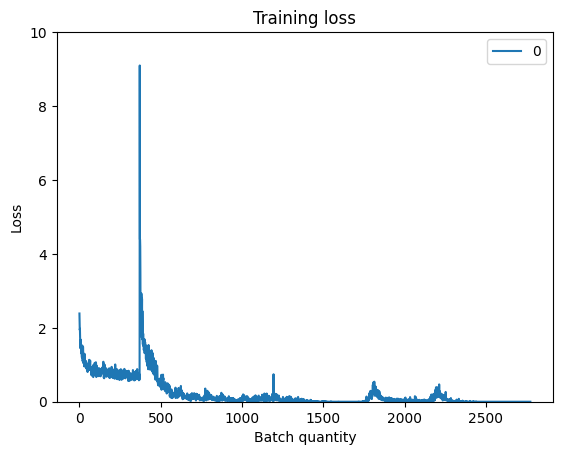

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(classifier.train_losses).plot.line()
plt.ylim(0,10)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Batch quantity")
plt.show()


Text(0.5, 0, 'Batch quantity')

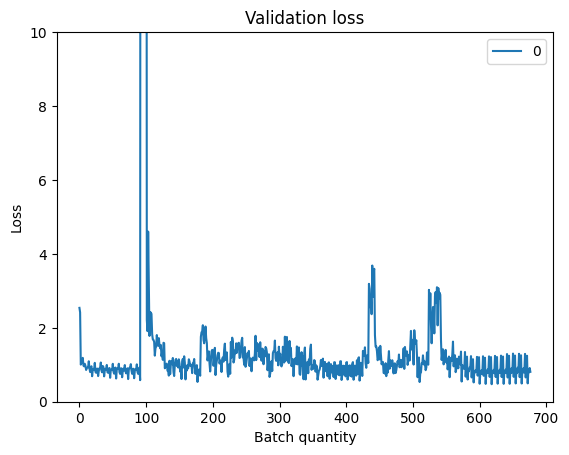

In [25]:
pd.DataFrame(classifier.val_losses).plot.line()
plt.ylim(0,10)
plt.title("Validation loss")
plt.ylabel("Loss")
plt.xlabel("Batch quantity")


**Evaluating the predictions**

In [26]:
predictions_ = []
y_true_ = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(classifier.test_dataloader()):
        data, labels = data.cpu(), labels.cpu()
        y_proba = nn.functional.softmax(classifier.forward(data), dim=1)
        y_hat = torch.argmax(y_proba, axis=1)
        predictions_.append(y_hat.view(-1))  # Reshape y_hat to have size (batch_size,)
        y_true_.append(labels.view(-1))     # Reshape labels to have size (batch_size,)
        if batch_idx == 10:
            break

predictions = torch.cat(predictions_, dim=0) # Concatenate all tensors in predictions_ along the 0-th dimension
y_true = torch.cat(y_true_, dim=0)           # Concatenate all tensors in y_true_ along the 0-th dimension


In [27]:
try:
  do_something()
except Exception:
  pass
predictions = torch.stack(predictions_).view(-1)
y_true = torch.stack(y_true_).view(-1)

In [28]:
classification_report_ = classification_report(y_true, predictions)
print(classification_report_)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.62      0.83      0.71         6
           2       0.40      0.86      0.55         7
           3       0.88      0.64      0.74        11
           4       1.00      0.50      0.67         2
           5       0.73      0.73      0.73        15
           6       0.93      0.76      0.84        17
           7       1.00      0.50      0.67         4

    accuracy                           0.73        66
   macro avg       0.82      0.70      0.72        66
weighted avg       0.80      0.73      0.74        66



In [29]:
cm = confusion_matrix(y_true, predictions)

<Axes: >

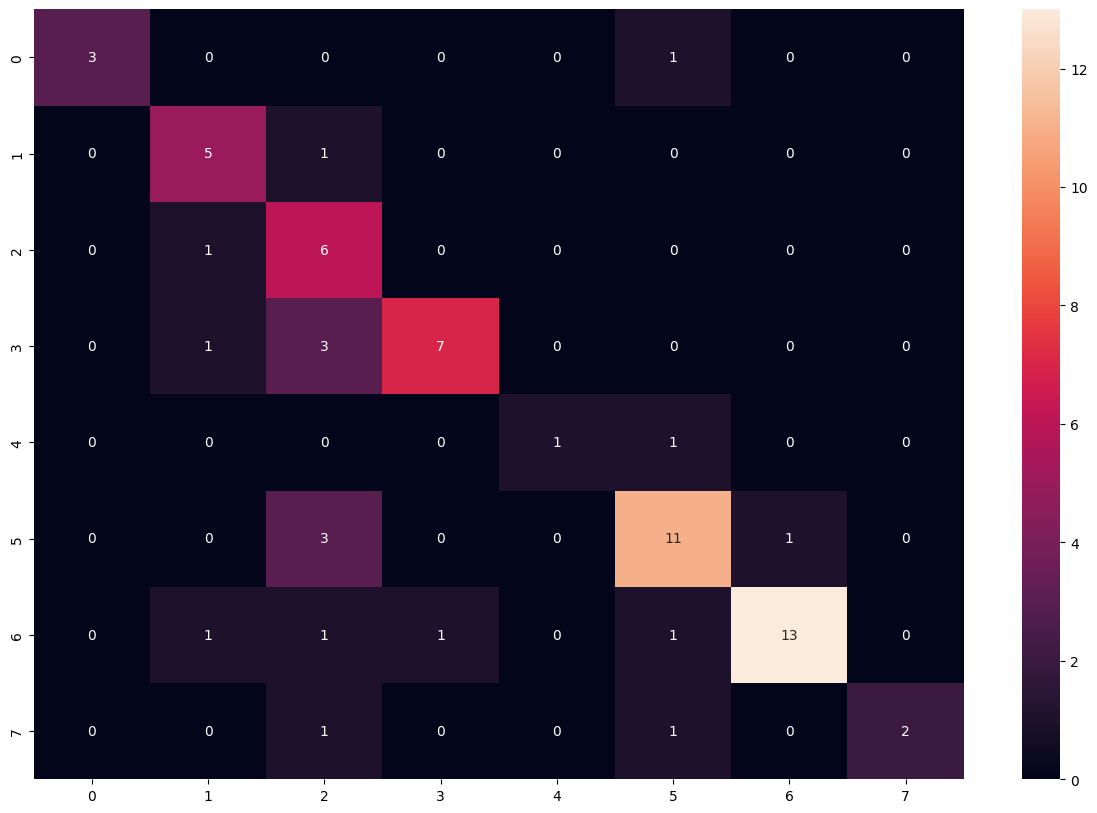

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(np.round(cm, 2)), annot=True, fmt='g')

**Accuracy**

In [33]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, predictions)
print('Accuracy:', accuracy)

Accuracy: 0.7272727272727273
